# Pymodis download data

In [10]:
from pymodis import downmodis
import glob

# Variables for data download
dest = "data/" # This directory must already exist BTW
tiles = "h19v08" # That's the MODIS tile covering northern Europe
day = "2019.11.30"
enddate = "2019.09.30" # The download works backward, so that enddate is anterior to day=
product = "MOD13A1.006"
user = "elorrez"
password = "Efbw2019!"

# Instantiate download class, connect and download
modis_down = downmodis.downModis(destinationFolder=dest, tiles=tiles, today=day, enddate=enddate, product=product, user =user, password=password)
modis_down.connect()
modis_down.downloadsAllDay()

# Check that the data has been downloaded
MODIS_files = glob.glob(dest + '*.hdf')
print(MODIS_files)

['data\\MOD13A1.A2019273.h19v08.006.2019290001416.hdf', 'data\\MOD13A1.A2019289.h19v08.006.2019306011948.hdf', 'data\\MOD13A1.A2019305.h19v08.006.2019323201907.hdf', 'data\\MOD13A1.A2019321.h19v08.006.2019337235426.hdf', 'data\\MOD13A1.A2020241.h17v07.006.2020261220412.hdf']


# pyhdf open data

0 500m 16 days NDVI
1 500m 16 days EVI
2 500m 16 days VI Quality
3 500m 16 days red reflectance
4 500m 16 days NIR reflectance
5 500m 16 days blue reflectance
6 500m 16 days MIR reflectance
7 500m 16 days view zenith angle
8 500m 16 days sun zenith angle
9 500m 16 days relative azimuth angle
10 500m 16 days composite day of the year
11 500m 16 days pixel reliability

Data: 
 [[4462 4594 4536 ... 3465 2590 2537]
 [4462 4846 4846 ... 4366 3304 2625]
 [4287 4877 4584 ... 3074 2899 2530]
 ...
 [2344 2010 1959 ... 5789 5828 5893]
 [2344 2325 2627 ... 5198 4815 5296]
 [2371 2325 2504 ... 5402 5809 4217]]
{'_FillValue': -3000,
 'add_offset': 0.0,
 'add_offset_err': 0.0,
 'calibrated_nt': 5,
 'long_name': '500m 16 days EVI',
 'scale_factor': 10000.0,
 'scale_factor_err': 0.0,
 'units': 'EVI',
 'valid_range': [-2000, 10000]}
long_name 500m 16 days EVI
units EVI
valid_range [-2000, 10000]
_FillValue -3000
scale_factor 10000.0
scale_factor_err 0.0
add_offset 0.0
add_offset_err 0.0
calibrated_nt 5

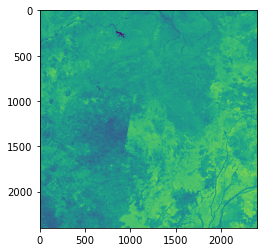

In [18]:
from pyhdf.SD import SD, SDC
file_name = 'data/MOD13A1.A2019273.h19v08.006.2019290001416.hdf'
file = SD(file_name, SDC.READ)

# print SDS names
datasets_dic = file.datasets()

for idx, sds in enumerate(datasets_dic.keys()):
    print(idx, sds )
    
# get data

sds_obj = file.select('500m 16 days EVI') # select sds
data = sds_obj.get() # get sds data
print( '\nData: \n', data )

# get attributes

import pprint

pprint.pprint(sds_obj.attributes() )

for key, value in sds_obj.attributes().items():
    print( key, value )
    if key == 'add_offset':
        add_offset = value  
    if key == 'scale_factor':
        scale_factor = value

print( '\nadd_offset:', add_offset, type(add_offset) )
print( '\nscale_factor:', scale_factor, type(scale_factor) )

data = (data - add_offset) * scale_factor

print( '\nData with offset and scale factor:\n', data )

from matplotlib.pyplot import imshow
imshow(sds_obj.get())

imshow(data)

# Gdal open and process based on quality (NDVI)

In [28]:
from osgeo import gdal
import numpy as np

# Get subdatasets of the first file of the MODIS_file list
sds = gdal.Open(MODIS_files[0], gdal.GA_ReadOnly).GetSubDatasets()

# Looking at the product description in the 'MODIS products table', we know that NDVI is the first SDS and there is a 
# pixel reliability layer in the 12th SDS. Let's see what they look like when opened with GDAL
# Note, unlike getRasterBand() which starts counting from one, the output of GetSubDatasets() is simply a list of tupples
# so normal python index applies here
print(sds[0])
print(sds[11])

('HDF4_EOS:EOS_GRID:"data\\MOD13A1.A2019273.h19v08.006.2019290001416.hdf":MODIS_Grid_16DAY_500m_VI:500m 16 days NDVI', '[2400x2400] 500m 16 days NDVI MODIS_Grid_16DAY_500m_VI (16-bit integer)')
('HDF4_EOS:EOS_GRID:"data\\MOD13A1.A2019273.h19v08.006.2019290001416.hdf":MODIS_Grid_16DAY_500m_VI:500m 16 days pixel reliability', '[2400x2400] 500m 16 days pixel reliability MODIS_Grid_16DAY_500m_VI (8-bit integer)')


In [29]:
# Every subdataset is represented by a tupple; we only need the first element of that tupple to read the datasets with gdal.Open

# Open NDVI dataset, we'll keep it and re-use it later for the dimension and projection information it contains
vi = gdal.Open(sds[0][0])

In [30]:
# Define offsets and width of data chunck we want to read as array
width = 500
height = 500
xOff = 400
yOff = 400

# Read data in arrays
# NDVI
vi_src = gdal.Open(sds[0][0])
vi_np = vi_src.ReadAsArray(xOff, yOff, width, height)

# QA
QA_src = gdal.Open(sds[11][0])
QA_np = QA_src.ReadAsArray(xOff, yOff, width, height)


# Let's take a quick look at the dimension of that first array
print(vi_np.shape)

(500, 500)


In [31]:
# Perform value replacement and drop QA layer
vi_np[np.logical_and(QA_np != 0, QA_np != 1)] = -3000
# De-allocate QA array
QA_np = None

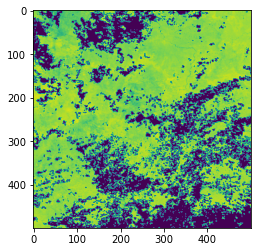

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(vi_np)
plt.show()

In [33]:
# Geotransform is a tupple of 6, that contains offset and resolution of the dataset. See gdal doc for more details
def updateGeoTransforms(srcGeo, xOff, yOff):
    """
    Create a new geotransform list based on a source geoTransform and an offset
    Returns a list of 6
    :param srcGeo: The geoTransfor of the uncroped dataset retrieved using GetGeoTransform()
    :param xOff: x offset used for cropping
    :param yOff: y offset used for cropping
    """
    out = [srcGeo[0] + xOff * srcGeo[1], srcGeo[1], srcGeo[2], srcGeo[3] + yOff * srcGeo[5], srcGeo[4], srcGeo[5]]
    return out

In [34]:
import os

# Get Geotransforms and projection of original dataset
geoT = vi.GetGeoTransform()
proj = vi.GetProjection()

# Create new dataset to write array to
outfile_name = os.path.join(dest, 'MODIS_NDVI.tif')
driver = gdal.GetDriverByName('GTiff')
# Create empty dataset using array dimentions
dataset = driver.Create(outfile_name, width, height, 1, gdal.GDT_Int16)
dataset.SetGeoTransform(updateGeoTransforms(geoT, xOff, yOff))
dataset.SetProjection(proj)
dataset.GetRasterBand(1).SetNoDataValue(-3000)
dataset.GetRasterBand(1).WriteArray(vi_np)

0

In [35]:
# Close datasets and unallocate arrays
dataset = None
vi_np = None
vi = None
vi_src = None
QA_src = None

# Gdal open and process based on quality (EVI)

('HDF4_EOS:EOS_GRID:"data\\MOD13A1.A2019273.h19v08.006.2019290001416.hdf":MODIS_Grid_16DAY_500m_VI:500m 16 days EVI', '[2400x2400] 500m 16 days EVI MODIS_Grid_16DAY_500m_VI (16-bit integer)')
('HDF4_EOS:EOS_GRID:"data\\MOD13A1.A2019273.h19v08.006.2019290001416.hdf":MODIS_Grid_16DAY_500m_VI:500m 16 days pixel reliability', '[2400x2400] 500m 16 days pixel reliability MODIS_Grid_16DAY_500m_VI (8-bit integer)')
(2400, 2400)


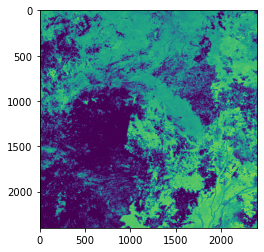

In [36]:
# Get subdatasets of the first file of the MODIS_file list
sds = gdal.Open(MODIS_files[0], gdal.GA_ReadOnly).GetSubDatasets()

# Looking at the product description in the 'MODIS products table', we know that NDVI is the first SDS and there is a 
# pixel reliability layer in the 12th SDS. Let's see what they look like when opened with GDAL
# Note, unlike getRasterBand() which starts counting from one, the output of GetSubDatasets() is simply a list of tupples
# so normal python index applies here
print(sds[1])
print(sds[11])

# Define offsets and width of data chunck we want to read as array
width = 500
height = 500
xOff = 400
yOff = 400

# Read data in arrays
# NDVI
vi_src = gdal.Open(sds[1][0])
vi_np = vi_src.ReadAsArray()

# QA
QA_src = gdal.Open(sds[11][0])
QA_np = QA_src.ReadAsArray()


# Let's take a quick look at the dimension of that first array
print(vi_np.shape)

# Perform value replacement and drop QA layer
vi_np[np.logical_and(QA_np != 0, QA_np != 1)] = -3000
# De-allocate QA array
QA_np = None

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(vi_np)
plt.show()


In [37]:
# Close datasets and unallocate arrays
dataset = None
vi_np = None
vi = None
vi_src = None
QA_src = None